In [6]:
from IPython.display import display

from pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    FullGrad,
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import (
    show_cam_on_image,
    deprocess_image,
    preprocess_image,
)
import torch
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import cv2

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define the transformation to be applied to the test images
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

Using mps device


In [8]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Specify the path to the test set folder
testset_path0 = "../storage/images/apple_extended_unedited/Test"

# Specify the path to the saved trained model
model_path0 = "/Users/stephandekker/workspace/pink_lady/storage/data/generated/20230622-212858_resnet18_more_pinky_loss.pt"


testset_path1 = "../storage/images/apple_extended_unedited/Test"
model_path1 = "/Users/stephandekker/workspace/pink_lady/storage/data/generated/20230622-212728_resnet18_more_pinky_loss.pt"


In [9]:
# Load the trained model
model0 = torch.load(model_path0)
model0.to(device)
model0.eval()

model1 = torch.load(model_path1)
model1.to(device)
model1.eval()


# define the lists of false positives and false negatives in a dataset
def img_check_setup(testset_path, model, device=device, transform=transform):
    # Create the test set dataset
    testset = ImageFolder(testset_path, transform=transform)
    testsetX = ImageFolder(testset_path, transform=transform)
    testsetX = testsetX.class_to_idx
    labels = {value: key for key, value in testsetX.items()}

    # Lists to store mislabeled images
    mislabeled_Blotch_Apple = []
    mislabeled_Normal_Apple = []
    mislabeled_Rot_Apple = []
    mislabeled_Scab_Apple = []
    mislabeled_Blotch_Apple_pred = []
    mislabeled_Normal_Apple_pred = []
    mislabeled_Rot_Apple_pred = []
    mislabeled_Scab_Apple_pred = []

    # Iterate over the images in the test set
    for image_path, label in testset.imgs:
        # Load and preprocess the image
        image = transform(Image.open(image_path)).unsqueeze(0).to(device)
        

        # Forward pass through the model
        with torch.no_grad():
            output = model(image)

        # Get the predicted label
        _, predicted_label = torch.max(output, 1)

        # Compare the predicted label with the ground truth label
        if predicted_label != label:
            if label == 0:  # blotted apples
                mislabeled_Blotch_Apple.append(image_path[len(testset_path) :])
                mislabeled_Blotch_Apple_pred.append([(image_path[len(testset_path) :]),predicted_label.item(), label])
                # mislabeled_Blotch_Apple.append([(image_path[len(testset_path) :]),predicted_label.item(), label])
            elif label == 1:  # normal apples
                mislabeled_Normal_Apple.append(image_path[len(testset_path) :])
                mislabeled_Normal_Apple_pred.append([(image_path[len(testset_path) :]),predicted_label.item(), label])
            elif label == 2:  # rotten apples
                mislabeled_Rot_Apple.append(image_path[len(testset_path) :])
                mislabeled_Rot_Apple_pred.append([(image_path[len(testset_path) :]),predicted_label.item(), label])
            elif label == 3:  # scabbed apples
                mislabeled_Scab_Apple.append(image_path[len(testset_path) :])
                mislabeled_Rot_Apple_pred.append([(image_path[len(testset_path) :]),predicted_label.item(), label])
            
            x = mislabeled_Blotch_Apple, mislabeled_Normal_Apple, mislabeled_Rot_Apple, mislabeled_Scab_Apple, mislabeled_Blotch_Apple_pred, mislabeled_Normal_Apple_pred, mislabeled_Rot_Apple_pred, mislabeled_Scab_Apple_pred


    return x , labels

# diplays a list and its 'name'
def img_check_show(imgcheck):
    variable_name = [name for name in globals() if globals()[name] is imgcheck][0]
    print(f"{variable_name} contains {len(imgcheck)} mislabeled images")
    for image_path in imgcheck:
        print(image_path)
        # display(Image.open(image_path))  # uncoment if you want to see the images
    return None


In [52]:
from modules.myFunctions import test_model


model_test0 = test_model(model0, testset_path0, device)
print()
model_test1 = test_model(model1, testset_path1, device)


Overall accuracy: 0.7537
Normal Apple accuracy: 0.6053
Abnormal Apple accuracy: 0.8125

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}
Confusion Matrix:
[[20  0  0 10]
 [ 5 23  6  4]
 [ 0  0 34  4]
 [ 1  1  2 24]]

Overall accuracy: 0.7687
Normal Apple accuracy: 0.6316
Abnormal Apple accuracy: 0.8229

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}
Confusion Matrix:
[[20  2  0  8]
 [ 5 24  5  4]
 [ 0  0 37  1]
 [ 1  2  3 22]]


In [11]:


# run the check for both file_paths
check_0= img_check_setup(testset_path0, model0, device=device, transform=transform)
check_1 = img_check_setup(testset_path1, model1, device=device, transform=transform)



check0 = check_0[0]
check1 = check_1[0]

check0_blotch, check0_normal, check0_rotten, check0_scab = check0[0], check0[1], check0[2], check0[3]
check1_blotch, check1_normal, check1_rotten, check1_scab = check1[0], check1[1], check1[2], check1[3]

# # display the results
# img_check_show(check0_falseNegatives0)
# img_check_show(check0_falsePositives0)
# print()
# img_check_show(check1_falseNegatives0)
# img_check_show(check1_falsePositives0)

# labels = check0[1]


In [12]:
labels = check_0[1] 
# labels = check0_blotch
print(labels)

{0: 'Blotch_Apple', 1: 'Normal_Apple', 2: 'Rot_Apple', 3: 'Scab_Apple'}


In [13]:

test_label = check0[0]
test_label = check0_blotch
for item in test_label: 
    print(item)

/Blotch_Apple/123.jpg
/Blotch_Apple/126.jpg
/Blotch_Apple/130.jpg
/Blotch_Apple/131.jpg
/Blotch_Apple/134.jpg
/Blotch_Apple/135.jpg
/Blotch_Apple/138.jpg
/Blotch_Apple/139.jpg
/Blotch_Apple/140.jpg
/Blotch_Apple/141.jpg
/Blotch_Apple/142.jpg
/Blotch_Apple/143.jpg
/Blotch_Apple/145.jpg
/Blotch_Apple/147.jpg


In [14]:

test_label = check0[5]
for item in test_label: 
    print(item)

['/Normal_Apple/10.jpg', 0, 1]
['/Normal_Apple/10th.jpg', 3, 1]
['/Normal_Apple/11th.jpg', 3, 1]
['/Normal_Apple/12th.jpg', 3, 1]
['/Normal_Apple/14th.jpg', 3, 1]
['/Normal_Apple/1st.jpg', 2, 1]
['/Normal_Apple/2nd.jpg', 2, 1]
['/Normal_Apple/3rd.jpg', 2, 1]
['/Normal_Apple/44.jpg', 2, 1]
['/Normal_Apple/4th.jpg', 0, 1]
['/Normal_Apple/57.jpg', 3, 1]
['/Normal_Apple/5th.jpg', 2, 1]
['/Normal_Apple/70083966-single-orange-or-yellow-color-apple-or-fruit-with-vitamin-for-healthy-diet-isolated-on-white-backgro.jpg', 2, 1]
['/Normal_Apple/7th.jpg', 0, 1]
['/Normal_Apple/81.jpg', 2, 1]
['/Normal_Apple/8th.jpg', 3, 1]


In [15]:

test_label = check0[6]
for item in test_label: 
    print(item)

['/Rot_Apple/istockphoto-654588270-612x612.jpg', 1, 2]
['/Rot_Apple/t83m2k.jpg', 3, 2]
['/Rot_Apple/td97ab.jpg', 3, 2]
['/Rot_Apple/wilted-rotten-apple-isolated-on-260nw-338996867.jpg', 1, 2]
['/Scab_Apple/17-0814-tree_unknownC_img4-26e35a1-1024x683.jpg', 0, 3]
['/Scab_Apple/AnyConv.com__images (26).jpg', 2, 3]
['/Scab_Apple/F4134795-7A74-49F2-AD2D-C359C79B0852.jpeg', 2, 3]


In [16]:

test_label = check0[7]
for item in test_label: 
    print(item)

In [17]:
# img_check_show(check0_blotch)
# img_check_show(check1_blotch)
# img_check_show(check0_normal)
# img_check_show(check1_normal)
img_check_show(check0_rotten)
img_check_show(check1_rotten)
# img_check_show(check0_scab)
# img_check_show(check1_scab)

check0_rotten contains 4 mislabeled images
/Rot_Apple/istockphoto-654588270-612x612.jpg
/Rot_Apple/t83m2k.jpg
/Rot_Apple/td97ab.jpg
/Rot_Apple/wilted-rotten-apple-isolated-on-260nw-338996867.jpg
check1_rotten contains 2 mislabeled images
/Rot_Apple/istockphoto-654588270-612x612.jpg
/Rot_Apple/td97ab.jpg


In [18]:
img_check_show(check0_normal)


check0_normal contains 16 mislabeled images
/Normal_Apple/10.jpg
/Normal_Apple/10th.jpg
/Normal_Apple/11th.jpg
/Normal_Apple/12th.jpg
/Normal_Apple/14th.jpg
/Normal_Apple/1st.jpg
/Normal_Apple/2nd.jpg
/Normal_Apple/3rd.jpg
/Normal_Apple/44.jpg
/Normal_Apple/4th.jpg
/Normal_Apple/57.jpg
/Normal_Apple/5th.jpg
/Normal_Apple/70083966-single-orange-or-yellow-color-apple-or-fruit-with-vitamin-for-healthy-diet-isolated-on-white-backgro.jpg
/Normal_Apple/7th.jpg
/Normal_Apple/81.jpg
/Normal_Apple/8th.jpg


In [19]:
img_check_show(check1_normal)


check1_normal contains 14 mislabeled images
/Normal_Apple/10.jpg
/Normal_Apple/10th.jpg
/Normal_Apple/11th.jpg
/Normal_Apple/12th.jpg
/Normal_Apple/14th.jpg
/Normal_Apple/1st.jpg
/Normal_Apple/3rd.jpg
/Normal_Apple/44.jpg
/Normal_Apple/4th.jpg
/Normal_Apple/57.jpg
/Normal_Apple/5th.jpg
/Normal_Apple/70083966-single-orange-or-yellow-color-apple-or-fruit-with-vitamin-for-healthy-diet-isolated-on-white-backgro.jpg
/Normal_Apple/7th.jpg
/Normal_Apple/8th.jpg


In [20]:
img_check_show(check0_rotten)
img_check_show(check1_rotten)


check0_rotten contains 4 mislabeled images
/Rot_Apple/istockphoto-654588270-612x612.jpg
/Rot_Apple/t83m2k.jpg
/Rot_Apple/td97ab.jpg
/Rot_Apple/wilted-rotten-apple-isolated-on-260nw-338996867.jpg
check1_rotten contains 2 mislabeled images
/Rot_Apple/istockphoto-654588270-612x612.jpg
/Rot_Apple/td97ab.jpg


In [21]:
img_check_show(check0_scab)
img_check_show(check1_scab)


check0_scab contains 3 mislabeled images
/Scab_Apple/17-0814-tree_unknownC_img4-26e35a1-1024x683.jpg
/Scab_Apple/AnyConv.com__images (26).jpg
/Scab_Apple/F4134795-7A74-49F2-AD2D-C359C79B0852.jpeg
check1_scab contains 8 mislabeled images
/Scab_Apple/17-0814-tree_unknownC_img4-26e35a1-1024x683.jpg
/Scab_Apple/2ea9em1.jpg
/Scab_Apple/AnyConv.com__images (26).jpg
/Scab_Apple/AnyConv.com__images (65).jpg
/Scab_Apple/AnyConv.com__images (86).jpg
/Scab_Apple/F4134795-7A74-49F2-AD2D-C359C79B0852.jpeg
/Scab_Apple/dw027a.jpg
/Scab_Apple/pg4fhm.jpg


In [22]:
# get the duplicates in both lists.
def img_check_duplicates(list1, list2):
    duplicates = [x for x in list1 if x in list2]
    return duplicates

blotch_duplicates = img_check_duplicates(check0_blotch, check1_blotch)
normal_duplicates = img_check_duplicates(check0_normal, check1_normal)
rot_duplicates = img_check_duplicates(check0_rotten, check1_rotten)
scab_duplicates = img_check_duplicates(check0_scab, check1_scab)


In [23]:

# show it
img_check_show(blotch_duplicates)
print(blotch_duplicates)


blotch_duplicates contains 10 mislabeled images
/Blotch_Apple/130.jpg
/Blotch_Apple/134.jpg
/Blotch_Apple/135.jpg
/Blotch_Apple/139.jpg
/Blotch_Apple/140.jpg
/Blotch_Apple/141.jpg
/Blotch_Apple/142.jpg
/Blotch_Apple/143.jpg
/Blotch_Apple/145.jpg
/Blotch_Apple/147.jpg
['/Blotch_Apple/130.jpg', '/Blotch_Apple/134.jpg', '/Blotch_Apple/135.jpg', '/Blotch_Apple/139.jpg', '/Blotch_Apple/140.jpg', '/Blotch_Apple/141.jpg', '/Blotch_Apple/142.jpg', '/Blotch_Apple/143.jpg', '/Blotch_Apple/145.jpg', '/Blotch_Apple/147.jpg']


In [24]:
img_check_show(normal_duplicates)


normal_duplicates contains 14 mislabeled images
/Normal_Apple/10.jpg
/Normal_Apple/10th.jpg
/Normal_Apple/11th.jpg
/Normal_Apple/12th.jpg
/Normal_Apple/14th.jpg
/Normal_Apple/1st.jpg
/Normal_Apple/3rd.jpg
/Normal_Apple/44.jpg
/Normal_Apple/4th.jpg
/Normal_Apple/57.jpg
/Normal_Apple/5th.jpg
/Normal_Apple/70083966-single-orange-or-yellow-color-apple-or-fruit-with-vitamin-for-healthy-diet-isolated-on-white-backgro.jpg
/Normal_Apple/7th.jpg
/Normal_Apple/8th.jpg


In [25]:
img_check_show(rot_duplicates)


rot_duplicates contains 2 mislabeled images
/Rot_Apple/istockphoto-654588270-612x612.jpg
/Rot_Apple/td97ab.jpg


In [26]:
img_check_show(scab_duplicates)



scab_duplicates contains 3 mislabeled images
/Scab_Apple/17-0814-tree_unknownC_img4-26e35a1-1024x683.jpg
/Scab_Apple/AnyConv.com__images (26).jpg
/Scab_Apple/F4134795-7A74-49F2-AD2D-C359C79B0852.jpeg


In [27]:
# get the errors that are unique to each list

def img_check_unique(list1, list2):
    unique = [x for x in list1 if x not in list2]
    return unique

blotch_unique_check0 = img_check_unique(check0_blotch, check1_blotch)
normal_unique_check0 = img_check_unique(check0_normal, check1_normal)
rotten_unique_check0 = img_check_unique(check0_rotten, check1_rotten)
scab_unique_check0 = img_check_unique(check0_scab, check1_scab)
blotch_unique_check1= img_check_unique(check1_blotch, check0_blotch)
normal_unique_check1 = img_check_unique(check1_normal, check0_normal)
rotten_unique_check1 = img_check_unique(check1_rotten, check0_rotten)
scab_unique_check1 = img_check_unique(check1_scab, check0_scab)

# show it
img_check_show(blotch_unique_check0)
img_check_show(blotch_unique_check1)

blotch_unique_check0 contains 4 mislabeled images
/Blotch_Apple/123.jpg
/Blotch_Apple/126.jpg
/Blotch_Apple/131.jpg
/Blotch_Apple/138.jpg
blotch_unique_check1 contains 2 mislabeled images
/Blotch_Apple/124.jpg
/Blotch_Apple/144.jpg


In [28]:
img_check_show(normal_unique_check0)
img_check_show(normal_unique_check1)


normal_unique_check0 contains 2 mislabeled images
/Normal_Apple/2nd.jpg
/Normal_Apple/81.jpg
normal_unique_check1 contains 0 mislabeled images


In [29]:
img_check_show(rotten_unique_check0)
img_check_show(rotten_unique_check1)


rotten_unique_check0 contains 2 mislabeled images
/Rot_Apple/t83m2k.jpg
/Rot_Apple/wilted-rotten-apple-isolated-on-260nw-338996867.jpg
rotten_unique_check1 contains 0 mislabeled images


In [30]:
img_check_show(scab_unique_check0)
img_check_show(scab_unique_check1)


scab_unique_check0 contains 0 mislabeled images
scab_unique_check1 contains 5 mislabeled images
/Scab_Apple/2ea9em1.jpg
/Scab_Apple/AnyConv.com__images (65).jpg
/Scab_Apple/AnyConv.com__images (86).jpg
/Scab_Apple/dw027a.jpg
/Scab_Apple/pg4fhm.jpg


In [31]:
image_url = f'{testset_path1}/{check0_blotch[0]}'
img = cv2.imread(image_url)
print(image_url)

../storage/images/apple_extended_unedited/Test//Blotch_Apple/123.jpg


In [32]:
if img is None:
    print("Error: Failed to convert the image to RGB.")
else:
    print("Success: Converted the image to RGB.")

Success: Converted the image to RGB.


In [33]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])

print(input_tensor.shape)
print(type(input_tensor))

# Move the input tensor to the same device as the model
input_tensor = input_tensor.to(device)

torch.Size([1, 3, 224, 224])
<class 'torch.Tensor'>


In [34]:
# # get a single image rdea to be shown
# def get_single_image(image_path, image_name, transform=transform, device=device):
#     image_url = f"{image_path}{image_name}"
#     # img = cv2.imread(image_url)
#     # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
#     # img = cv2.resize(img, (224, 224))
#     # img = np.float32(img) / 255
#     # input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
#     input_tensor = transform(Image.open(image_url))
#     input_tensor = input_tensor.to(device)
#     return input_tensor

# input_tensor = get_single_image(testset_path1, false_negatives_check0_check1[0])



In [35]:
def get_image_url(image_path, image_name):
    image_url = f"{image_path}{image_name}"
    return image_url

# def image_preprocess(image_url, transform=transform, device=device):
#     img = cv2.imread(image_url)
#     if img is None:
#         print("Error: Failed to convert the image to RGB.")
#         return None

#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Switch from BGR to RGB
#     img = cv2.resize(img, (224, 224))
#     img = np.float32(img) / 255



#     input_tensor = transform(img).unsqueeze(0)
#     input_tensor = input_tensor.to(device)

#     return input_tensor

In [36]:
# As usual for classication, the target is the logit output
# before softmax, for that category.

def myGradcam(model, input_tensor, nr_of_classes):
    target_layers = [model.layer4[-1]]  # Resnet18 and 50: model.layer4[-1], from GradCAM GitHub documentation
    targets = [ClassifierOutputTarget([nr_of_classes])]

    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

    cam = np.uint8(255 * grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255 * img), cam, cam_image))
    return [Image.fromarray(images)]  # Return a list with the images as elements




In [37]:
get_image_url(testset_path0, img )
print(get_image_url(testset_path0, check0_blotch[0]))


../storage/images/apple_extended_unedited/Test/Blotch_Apple/123.jpg


In [38]:

# input_tensor = image_preprocess(get_image_url(testset_path0, false_negatives_check0_check1[0]))
# input_tensor.to(device)
camImages=myGradcam(model0, input_tensor,1)


In [39]:

# # Display the CAM image
# for img in camImages:
#     display(img)

In [40]:
# for item in false_negatives_check0_check1:
#     input_tensor = get_single_image(testset_path1, item)
#     camImages=myGradcam(model, input_tensor,1)
#     for img in camImages:
#         display(img)

# comparisons

In [41]:
apple_type = "blotch"
type_duplicates = blotch_duplicates
type_unique_check0 = blotch_unique_check0
type_unique_check1 = blotch_unique_check1


the number mislabeled blotch_apples in both lists are 10
/Blotch_Apple/130.jpg


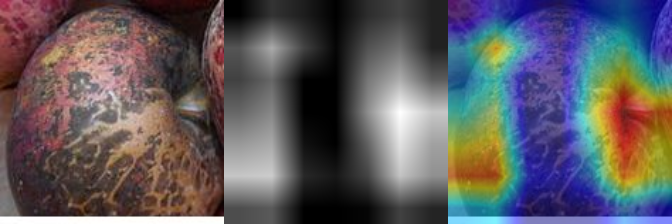

/Blotch_Apple/134.jpg


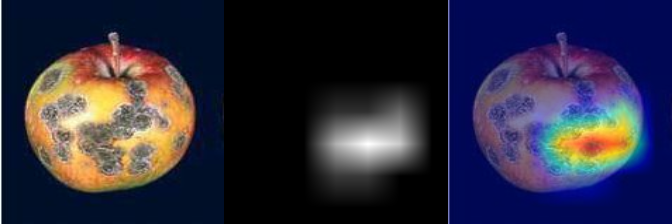

/Blotch_Apple/135.jpg


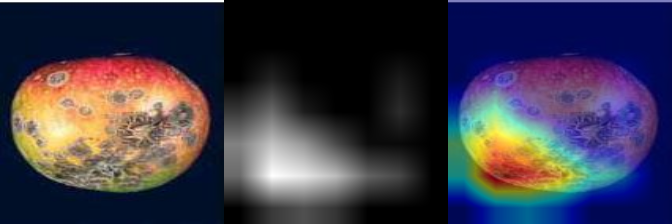

/Blotch_Apple/139.jpg


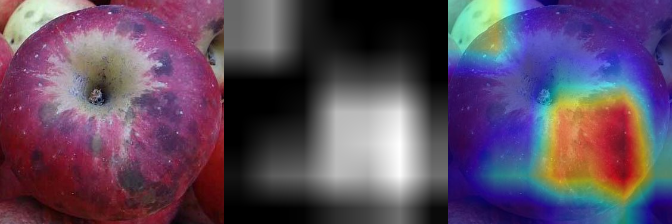

/Blotch_Apple/140.jpg


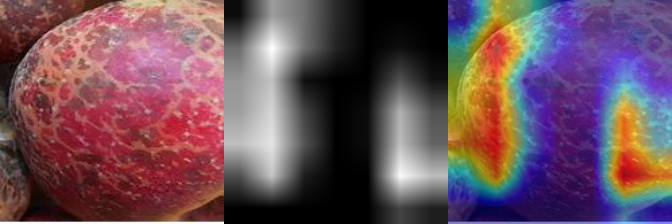

/Blotch_Apple/141.jpg


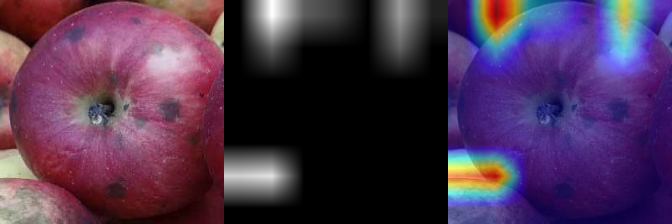

/Blotch_Apple/142.jpg


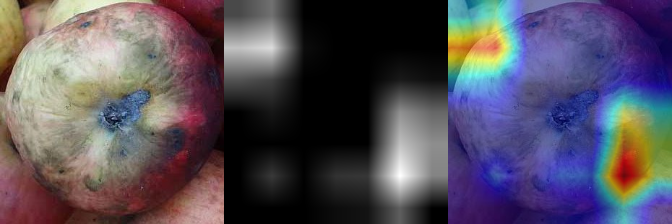

/Blotch_Apple/143.jpg


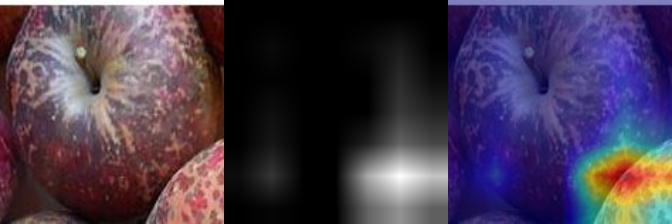

/Blotch_Apple/145.jpg


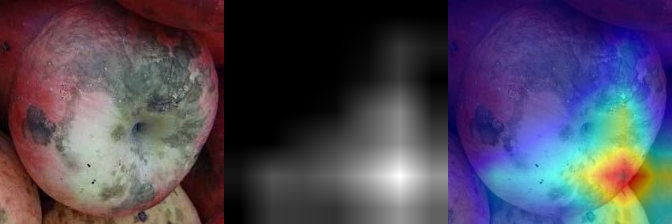

/Blotch_Apple/147.jpg


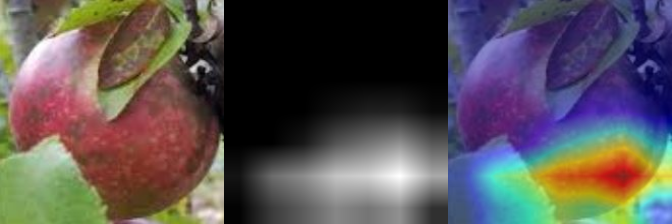

In [46]:
# duplicate mislabeled images
print(f'the number mislabeled {apple_type}_apples in both lists are {len(type_duplicates)}')

for img_path in blotch_duplicates:
    img = cv2.imread(testset_path0+img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    
    camImages=myGradcam(model0, input_tensor,1)
    for img in camImages:
        print(img_path)
        display(img)



the number of mislabled blotch_apples in set0 =  4
/Blotch_Apple/123.jpg


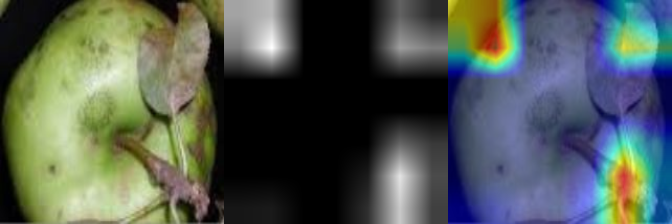

/Blotch_Apple/126.jpg


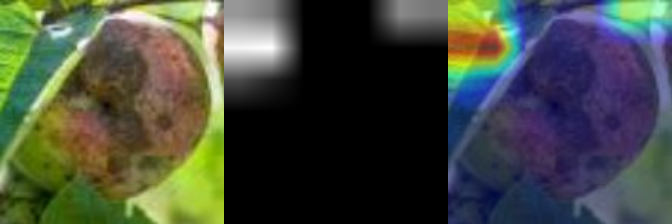

/Blotch_Apple/131.jpg


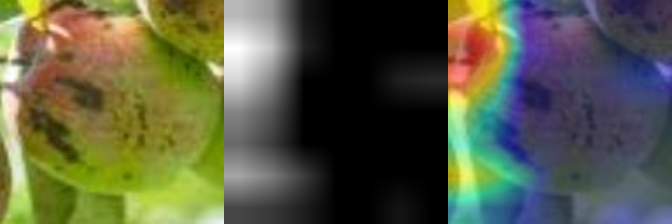

/Blotch_Apple/138.jpg


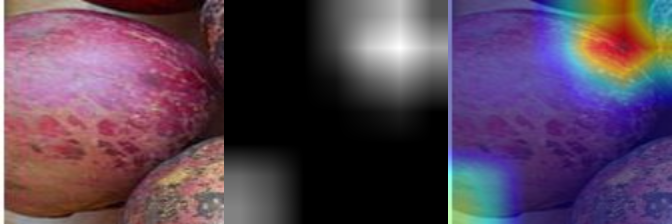

In [43]:
# the false negatives the 0th list
print(f'the number of mislabled {apple_type}_apples in set0 =  {len(type_unique_check0)}')

for img_path in type_unique_check0:
    img = cv2.imread(testset_path0+img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    
    camImages=myGradcam(model0, input_tensor,1)
    for img in camImages:
        print(img_path)
        display(img)

the number of mislabled blotch_apples in set0 =  2
/Blotch_Apple/124.jpg


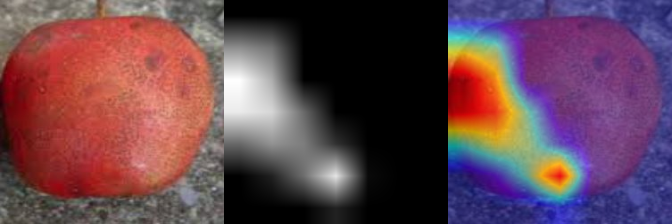

/Blotch_Apple/144.jpg


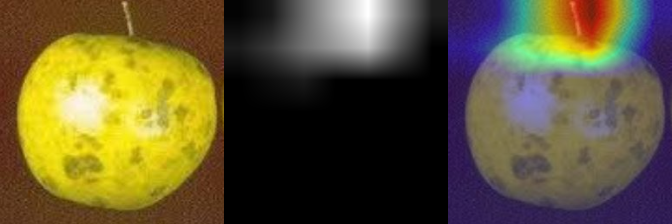

In [57]:
# the false negatives the 1th list
print(f'the number of mislabled {apple_type}_apples in set0 =  {len(type_unique_check1)}')

for img_path in type_unique_check1:
    img = cv2.imread(testset_path1+img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    camImages=myGradcam(model1, input_tensor,1)
    for img in camImages:
        print(img_path)
        display(img)

# false positives


In [45]:
# the false positives in both lists
print(f'the number of false positives in both lists are {len(false_positives_check0_check1)}')

for img_path in false_positives_check0_check1:
    img = cv2.imread(testset_path0+img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    
    camImages=myGradcam(model, input_tensor,0)
    for img in camImages:
        print(img_path)
        display(img)

NameError: name 'false_positives_check0_check1' is not defined

In [ ]:
# the false positives in the 0th list
print (f'the number of false positives in the 0th list is {len(false_positives_check0_unique)}')
       
for img_path in false_positives_check0_unique:
    img = cv2.imread(testset_path0+img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    
    camImages=myGradcam(model, input_tensor,0)
    for img in camImages:
        print(img_path)
        display(img)

In [ ]:
# the false positices in the 1st list
print (f'the number of false positives in the 1st list is {len(false_positives_check1_unique)}')
for img_path in false_positives_check1_unique:
    img = cv2.imread(testset_path1+img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    
    camImages=myGradcam(model, input_tensor,0)
    for img in camImages:
        print(img_path)
        display(img)

# WIP display the unique false positives/negatives side by side with its correct counterpart.

In [54]:
testset = ImageFolder(testset_path1, transform=transform)

In [56]:

# the false negatives the 1th list
print(f'the number of mislabled {apple_type}_apples in set0 =  {len(testset)}')

for img_path in type_unique_check1:
    img = cv2.imread(testset+img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    camImages=myGradcam(model1, input_tensor,1)
    for img in camImages:
        print(img_path)
        display(img)

the number of mislabled blotch_apples in set0 =  134


TypeError: Can't convert object to 'str' for 'filename'